In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [13]:
url = "https://raw.githubusercontent.com/akay6483/mmml-ecommerce/main/dataset/E-commerce%20Customer%20Behavior%20-%20Sheet1.csv"

df = pd.read_csv(url)
df.head()

,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,"1,120.2000",14,4.6000,True,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.5000,11,4.1000,False,18,Neutral
2,103,Female,43,Chicago,Bronze,510.7500,9,3.4000,True,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,"1,480.3000",19,4.7000,False,12,Satisfied
4,105,Male,27,Miami,Silver,720.4000,13,4.0000,True,55,Unsatisfied


In [14]:
# 1. Map Satisfaction Level
satisfaction_map = {'Unsatisfied': 0, 'Neutral': 1, 'Satisfied': 2}
df['Satisfaction_Numeric'] = df['Satisfaction Level'].map(satisfaction_map)
df['Satisfaction_Numeric'] = df['Satisfaction_Numeric'].fillna(df['Satisfaction_Numeric'].mode()[0])

# 2. Convert Boolean to Int
df['Discount_Numeric'] = df['Discount Applied'].astype(int)

# 3. Map Gender
df['Gender_Numeric'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Define Features and Target
features = ['Age', 'Gender_Numeric', 'Items Purchased', 'Average Rating', 
            'Discount_Numeric', 'Days Since Last Purchase', 'Satisfaction_Numeric']

X = df[features]
y = df['Total Spend']

print("Preprocessing complete.")

Preprocessing complete.


In [15]:
# Convert all feature values to numeric and handle errors
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Fill NaNs using median
X = X.fillna(X.median())
y = y.fillna(y.median())

print("Missing X values:", X.isnull().sum())
print("Missing y values:", y.isnull().sum())

Missing X values: Age                         0
Gender_Numeric              0
Items Purchased             0
Average Rating              0
Discount_Numeric            0
Days Since Last Purchase    0
Satisfaction_Numeric        0
dtype: int64
Missing y values: 0


In [16]:
# Scale the features (Important for Regularized Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier plotting later (optional)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42
)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data:  {X_test.shape}")

Training Data: (280, 7)
Testing Data:  (70, 7)


In [17]:
# Initialize models
# Alpha determines the strength of the penalty (regularization)
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1) # Lasso can zero out features completely

# Fit models
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

print("Both models trained successfully.")

Both models trained successfully.


In [18]:
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return [mae, mse, rmse, r2, mape]

# Predictions
ridge_pred = ridge_model.predict(X_test)
lasso_pred = lasso_model.predict(X_test)

# Collect Metrics
ridge_metrics = calculate_metrics(y_test, ridge_pred, "Ridge")
lasso_metrics = calculate_metrics(y_test, lasso_pred, "Lasso")

# Create Comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R² Score', 'MAPE (%)'],
    'Ridge Regression': ridge_metrics,
    'Lasso Regression': lasso_metrics
})

# Display
pd.options.display.float_format = '{:,.4f}'.format
print("--- Model Comparison ---")
display(comparison_df)

--- Model Comparison ---


,Metric,Ridge Regression,Lasso Regression
0,MAE,33.2928,33.6688
1,MSE,"1,937.6759","1,923.4220"
2,RMSE,44.0190,43.8568
3,R² Score,0.9857,0.9858
4,MAPE (%),3.7521,3.8279


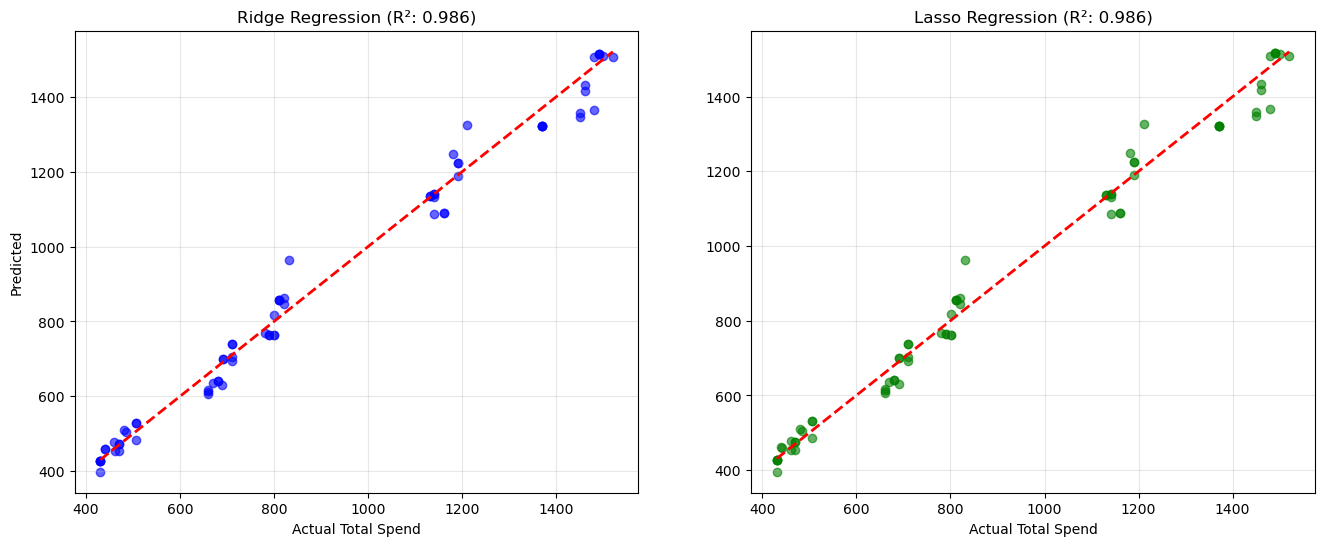

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ridge Plot
axes[0].scatter(y_test, ridge_pred, alpha=0.6, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_title(f"Ridge Regression (R²: {r2_score(y_test, ridge_pred):.3f})")
axes[0].set_xlabel("Actual Total Spend")
axes[0].set_ylabel("Predicted")
axes[0].grid(True, alpha=0.3)

# Lasso Plot
axes[1].scatter(y_test, lasso_pred, alpha=0.6, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title(f"Lasso Regression (R²: {r2_score(y_test, lasso_pred):.3f})")
axes[1].set_xlabel("Actual Total Spend")
axes[1].grid(True, alpha=0.3)

plt.show()

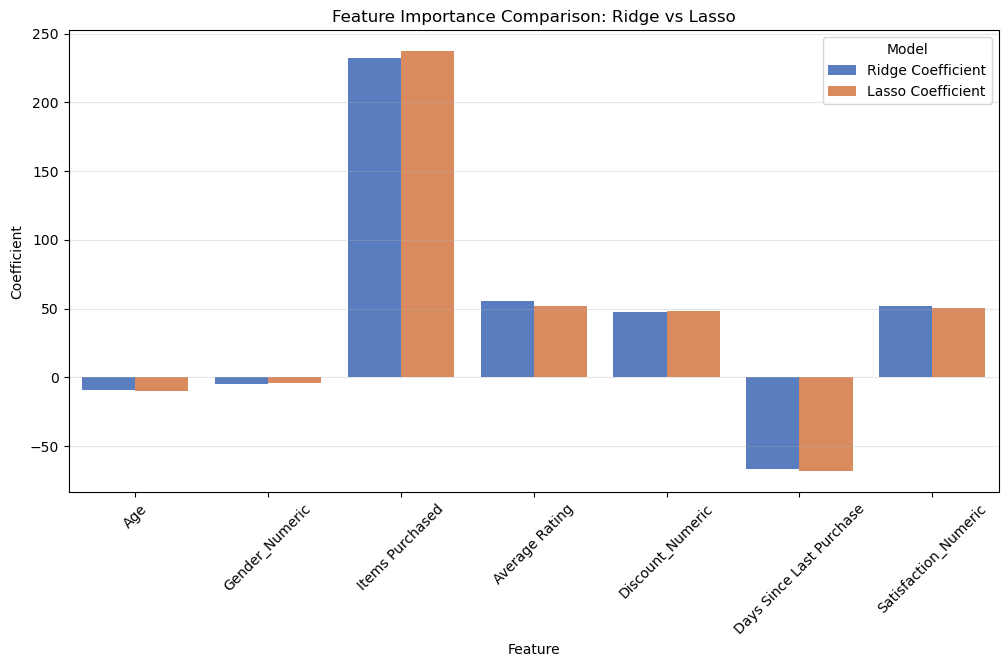

In [20]:
# Create DataFrame for Coefficients
coef_data = {
    'Feature': features,
    'Ridge Coefficient': ridge_model.coef_,
    'Lasso Coefficient': lasso_model.coef_
}
coef_df = pd.DataFrame(coef_data)

# Melt for seaborn plotting
coef_melted = coef_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')

plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Coefficient', hue='Model', data=coef_melted, palette='muted')
plt.title("Feature Importance Comparison: Ridge vs Lasso")
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.show()